In [12]:
%matplotlib inline

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import bernoulli, beta, norm, gamma

sns.set(style='ticks', font_scale=1)
blue, green, red, purple, gold, cyan = sns.color_palette("deep",6)

## An extremely brief introduction to Bayesian statistics

We've covered a few different statistical topics in the last few weeks, including OLS (ordinary least squares) regression, logistic regression, LDA, PCA, and ARMA (time series) models. With respect to a few of these, we've very briefly discussed the concept of the **likelihood function**. We'll dig into this concept a little more deeply in this notebook as a first step toward understanding Bayesian statistical modeling.

We'll borrow a slightly goofy example from [Statistical Rethinking](http://xcelab.net/rm/statistical-rethinking/) by Richard McElreath to illustrate what a likelihood function is.

Suppose you have a small globe, and you want to use it to estimate the proportion of the surface of the Earth that is covered by water. In order to do this, you toss it in the air, catch it, and then record whether land or water is underneath your right index finger.

Suppose the first nine tosses produce the following data, where W indicates water, and L indicates land: W L W W W L W L W

We can code this data numerically by using 1 to indicate water and 0 to indicate land: 1 0 1 1 1 0 1 0 1

This kind of data can be usefully modeled as a [Bernoulli random variable](https://en.wikipedia.org/wiki/Bernoulli_distribution). A Bernoulli random variable $Y$ can take the value 1 with probability $\theta$, or the value 0 with probability $1-\theta$. That is, a Bernoulli model has a single parameter $\theta$ that indicates the probability of the outcome $Y=1$.

More generally, the probability that $Y=y$ for a particular $\theta$ is given by: $\Pr(Y=y|\theta) = \theta^y \left(1-\theta\right)^{1-y}$

If $y=1$, this reduces to $\theta$, and if $y=0$, this reduces to $1-\theta$.

If we have a sequence $\mathbf{y}$ of $n$ independent observations of Bernoulli random variables, the probability of all $n$ observations is given by the product of the probabilities of each individual observation (independence allows us to calculate the joint probability of all $n$ observations by multiplying the individual probabilities):

\begin{equation}
\Pr(\mathbf{Y}=\mathbf{y}|\theta) = \prod_{i=1}^n\theta^{y_i} \left(1-\theta\right)^{1-y_i} = \theta^k \left(1-\theta \right)^{n-k}
\end{equation}

Here, $k$ indicates the number of ones in the vector $\mathbf{y}$.

If we know the value of $\theta$, we can use this to calculate the probability of a sequence of observations, but we don't typically know the value of $\theta$. It would be much more typical to want to use a vector $\mathbf{y}$ to *estimate* $\theta$.

As noted, the equation above gives us the probability of a particular sequence of observed values of $y$. The same equation is called a **likelihood function** if we treat the equation as a function of $\theta$, taking the sequence of $y$ values as fixed.

Assuming that our land and water observations from above are independent, we can use `bernoulli.pmf()` (pmf = probability mass function) to plot the likelihood function for different subsets of the nine observations:

In [4]:
bern = bernoulli.pmf # Bernoulli probability function
wl = ['L','W'] # for using the 1s and 0s to pick out L and W in figures
d = np.array([1,0,1,1,1,0,1,0,1]) # data
bern(k=d, p=0.25) # vector of probabilities for data d

array([ 0.25,  0.75,  0.25,  0.25,  0.25,  0.75,  0.25,  0.75,  0.25])

In [5]:
np.prod(bern(k=d, p=0.25)) # product of probabilities across nine observations

0.000102996826171875

In order to visualize the likelihood function for the first observation, the first four observations, and the first seven observations, and the full set of nine observations, we will use **grid approximation**. This means that we will create an array (a grid) of $\theta$ values for which we want to calculate the likelihood for these subsets of the data, then we will write a loop to do the calculations. It's an *approximation* because, mathematically speaking, $\theta$ is a continuous variable that can take any value between 0 and 1, but we'll just be considering a pre-determined set of values.

In [6]:
n_theta = 500 # number of theta values
theta = np.linspace(0,1,n_theta) # array of theta values
n_obs = np.array([1,4,7,9]) # array of values indicating the number of data points to take into account
like = np.zeros((4,n_theta)) # storage for likelihood functions

for i,nn in enumerate(n_obs):
    for j,th in enumerate(theta):
        like[i,j] = np.prod(bern(k=d[:nn], p=th)) # likelihood function

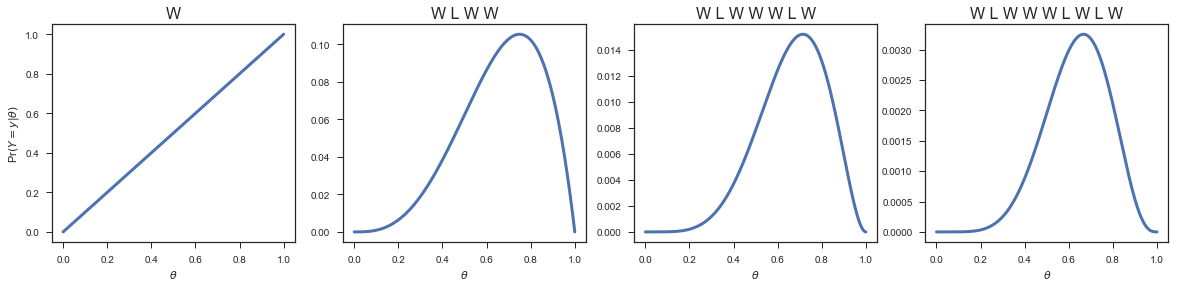

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for i in range(4):
    axes[i].plot(theta, like[i,:], lw=3)
    axes[i].set(xlabel=r'$\theta$')
    axes[i].set_title(' '.join([wl[j] for j in d[:n_obs[i]]]), fontsize=16)
axes[0].set(ylabel=r'Pr$\left(Y=y|\theta\right)$');

We can see a few interesting properties of the likelihood function in these figures. One is that more data tends to produce a narrower likelihood function - moving from left to right (i.e., from 1, to 4, to 7, to 9 data points), fewer values of $\theta$ are consistent with the larger data sets.

Another is that more data produces very small values for  the likelihood function - the functions in each panel are visually pretty similar because matplotlib scales the y axes to fit the curves nicely, but if you look at the specific values on the y axes, you can see that the values of the functions are quite different.

In some of the models that we've used in the past few weeks, the algorithms for finding model parameters are designed to find **maximum likelihood estimates**, or MLEs, i.e., values of the parameters that correspond to the largest value of the likelihood function.

In simple models like the Bernoulli model illustrated above, it's very easy to find the MLE of $\theta$. We can look at the figures and make a pretty good guess, or we can using Python:

In [8]:
for i in range(4):
    # argmax returns the index for the maximum value in an array
    print(theta[np.argmax(like[i,:])])

1.0
0.749498997996
0.713426853707
0.667334669339


In this particular case, we can also just divide the number of ones (i.e., the number of water observations) by the total number of observations, but this is not a general method for obtaining MLEs (and note that doing this produces slightly different values than did picking out the $\theta$ values at the highest points in the grid-approximated curves):

In [9]:
[d[:nn].sum()/nn for nn in n_obs]

[1.0, 0.75, 0.7142857142857143, 0.66666666666666663]

The likelihood function provides a link between data and unobserved quantities of interest (often instantiated as model parameters). Because of this, it is a crucially important part of any statistical model. For many models, it is pretty much the entirety of the model.

As mentioned, some of the models we've looked at in recent weeks find MLEs (e.g., logistic regression in `statsmodels`). Other models give MLEs, though they are not explicitly described in this way (e.g., OLS regression gives MLEs for a Gaussian likelihood function), and still others use a likelihood function but include additional structure such that the likelihood function is balanced against other considerations (e.g., the lasso, which balances the likelihood and the weighted sum of the parameter estimates).

## Bayes' rule

The likelihood function plays an important role in Bayesian statistics. In order to illustrate this, we'll first take a short detour to talk about Bayes' rule.

### Joint, marginal, and conditional probability

Here's a table illustrating the number of people (per 10,000) infected (or not) with *Bayesobacter radicalaris*, a.k.a. *Radical Bayesianism* (rows) and with positive or negative tests for *Bayesobacter* (columns):

Counts   | positive | negative | margin
---------|----------|----------|--------
infected | 285      | 15       | 300
not inf. | 970      | 8730     | 9700
margin   | 1255     | 8745     | 10000

### Joint probability

What's the *joint* probability of being infected **and** having a positive test, $\Pr(i,+)$?

Counts   | positive | negative | margin
---------|----------|----------|--------
infected | **285**  | 15       | 300
not inf. | 970      | 8730     | 9700
margin   | 1255     | 8745     | **10000**

$\displaystyle{\Pr(i,+) = \frac{285}{10000} = 0.0285}$

### Marginal probability

What's the *marginal* probability of being infected $\Pr(i)$?

Counts   | positive | negative | margin
---------|----------|----------|--------
infected | 285      | 15       | **300**
not inf. | 970      | 8730     | 9700
margin   | 1255     | 8745     | **10000**

$\displaystyle{\Pr(i) = \frac{300}{10000} = 0.03}$

### Conditional probability

What's the *conditional* probability of having a positive test, given that you're infected $\Pr(+|i)$?

Counts   | positive | negative | margin
---------|----------|----------|--------
infected | **285**  | 15       | **300**
not inf. | 970      | 8730     | 9700
margin   | 1255     | 8745     | 10000

$\displaystyle{\Pr(+|i) = \frac{\Pr(+,i)}{\Pr(i)} = \frac{285}{300} = 0.95}$

### Joint and conditional probabilities

The *joint* probability of $+$ and $i$ is equal to the *conditional* probability of $+$ given $i$ times the (marginal) probability of $i$:

$\displaystyle{\Pr(+,i) = \Pr(+|i)\Pr(i) = \frac{285}{300} \times \frac{300}{10000} = \frac{285}{10000}}$

Counts   | positive | negative | margin
---------|----------|----------|--------
infected | **285**  | 15       | **300**
not inf. | 970      | 8730     | 9700
margin   | 1255     | 8745     | **10000**

### Bayes' rule

One consequence of this relationship between joint, marginal, and conditional probabilities is Bayes' rule:

$$\begin{aligned}\Pr(i,+) &= \Pr(+,i) & \text{order of the terms is irrelevant}\\
\Pr(i|+)\Pr(+) & = \Pr(+|i)\Pr(i) & \text{rewriting each joint probability as a conditional times a marginal}\\
\Pr(i|+) &= \frac{\Pr(+|i)\Pr(i)}{\Pr(+)} & \text{re-arrange terms}\\
&= \frac{\Pr(+|i)\Pr(i)}{\Pr(+|i)\Pr(i) + \Pr(+|\sim i)\Pr(\sim i)} & \text{expand the denominator}\\
\end{aligned}$$

### An uncontroversial application of Bayes' rule

Suppose you are worried that you've been infected with *Bayesobacter radicalaris*, so you go to the doctor to get tested.

As described above, the base rate of infection in the population is $\Pr(i) = 0.03$ (note that this implies that the probability of *not* being infected is $\Pr(\sim i) = 0.97$), the probability of a positive test result given infection is $\Pr(+|i) = 0.95$, and the probability of a positive test result given *no* infection is $\Pr(+|\sim i) = 0.10$.

Now suppose you get a positive test result. What's the probability that you're infected, given the positive test result $\Pr(i|+)$?

Plug the numbers into Bayes' rule:

$$\begin{aligned}
\Pr(i|+) &= \frac{\Pr(+|i)\Pr(i)}{\Pr(+|i)\Pr(i) + \Pr(+|\sim i)\Pr(\sim i)}\\
&\\
&= \frac{0.95 \times 0.03}{0.95 \times 0.03 + 0.10 \times 0.97}\\
&\\
&\approx 0.23
\end{aligned}$$

### Frequency tree representation

A frequency tree can make figuring this out a little more intuitive. If you want to know the probability of an infection given a positive test result, you just take the number of cases that are infected **and** have a positive test result and you divide by the number of cases with positive test results:

<img src="freq_tree.png">

$\Pr(i|+) = 285/(285 + 970) \approx 0.23$

### The parts of Bayes' rule

The different terms in the equation illustrating Bayes' rule above have specific names.

\begin{equation}
\Pr(i|+) = \frac{\Pr(+|i)\Pr(i)}{\Pr(+)}
\end{equation}

In this particular version of the equation, $\Pr(i|+)$ is the **posterior probability** of being infected given a positive test result.

$\Pr(+|i)$ is the **likelihood**.

$\Pr(i)$ is the **prior probability** of being infected.

And $\Pr(+) = \Pr(+|i)\Pr(i) + \Pr(+|\sim i)\Pr(\sim i)$ is the marginal likelihood (i.e., it's the likelihood weighted by all possible prior values and summed up).

## Bayesian estimation of Earth's water coverage

Returning to our globe-tossing example above, we can illustrate the use of Bayes' rule in a situation that is slightly more complicated and representative of real life uses of Bayesian statistical modeling than is this disease diagnosis example.

A Bayesian model of the water-coverage data gives us a set of numbers indicating the relative plausibility of each value of $\theta$. It does this by considering all the data points and updating the relative plausibilities of every possible value of $\theta$ accordingly.

We can illustrate this observation-by-observation, showing how, at each step, the prior distribution for $\theta$ is the posterior from the previous step. We'll go over a mathematical formulation of this model later.

In the water-coverage case, we already know our likelihood function (and our data). We can add to this an initial **prior** probability function for $\theta$ under which every possible value of $\theta$ is equally likely (i.e., a uniform prior), and then we'll use Bayes' rule to estimate the **posterior** distribution of plausible values of $\theta$ after each observation of W or L.

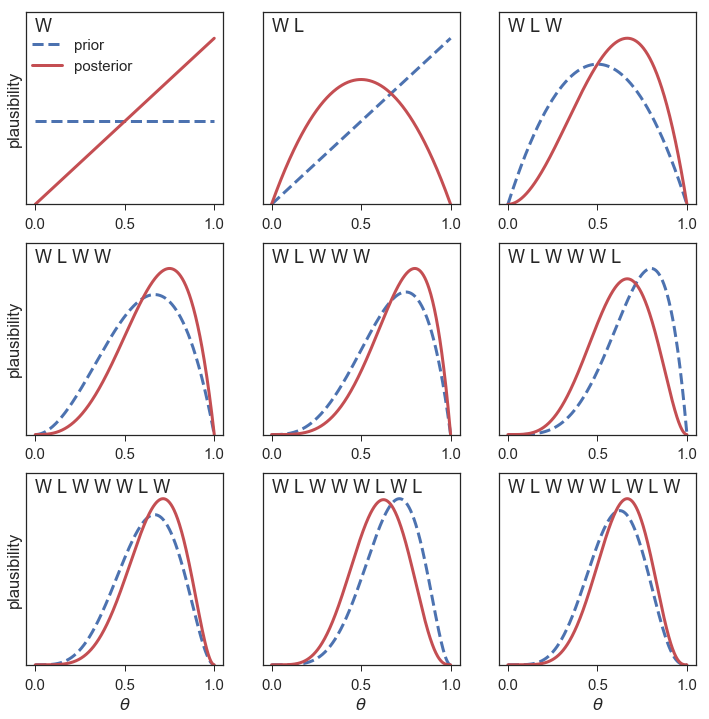

In [14]:
sns.set(style='ticks', font_scale=1.5) # re-setting some plotting parameters
fig, axes = plt.subplots(3, 3, figsize=(12,12))
axes = axes.ravel()

prob = np.ones(n_theta) # initial flat prior
prob = prob/np.sum(prob) # normalize so that it 'integrates' to one

title = [] # for building up a sequence of Ws and Ls

for i,dv in enumerate(d):
    title.append(wl[dv])
    l_prior, = axes[i].plot(theta,prob,'--',lw=3) # plot the prior at step i
    like = bern(dv,theta) # calculate the likelihood
    prob = prob * like # update the prior to get the posterior
    prob = prob/np.sum(prob) # normalize it
    l_post, = axes[i].plot(theta,prob,lw=3,color=red) # plot it
    y_up = axes[i].get_ylim()[1] # adjust upper limit of y axis
    axes[i].set(yticks=[], ylim=(0,1.1*y_up))
    if i in [0,3,6]:
        axes[i].set(ylabel='plausibility') # only put y axis labels on leftmost panels
    if i > 5:
        axes[i].set(xlabel=r'$\theta$') # only put x axis labels on bottom panels
    axes[i].text(0,.9*axes[i].get_ylim()[1],' '.join(title)) # put data in top left corner
    if i == 0:
        axes[i].legend([l_prior,l_post],['prior','posterior'],loc=(0,.65))

Note that, at each step, an observation of W shifts the prior at that step toward one. Note, too, that the distribution gets narrower as the number of observations increases. Finally, note that each additional observation has a slightly smaller overall effect as the total number of observations increases.

If the specific order of the observations were different, the endpoint would be the same, but each step along the way could be different:

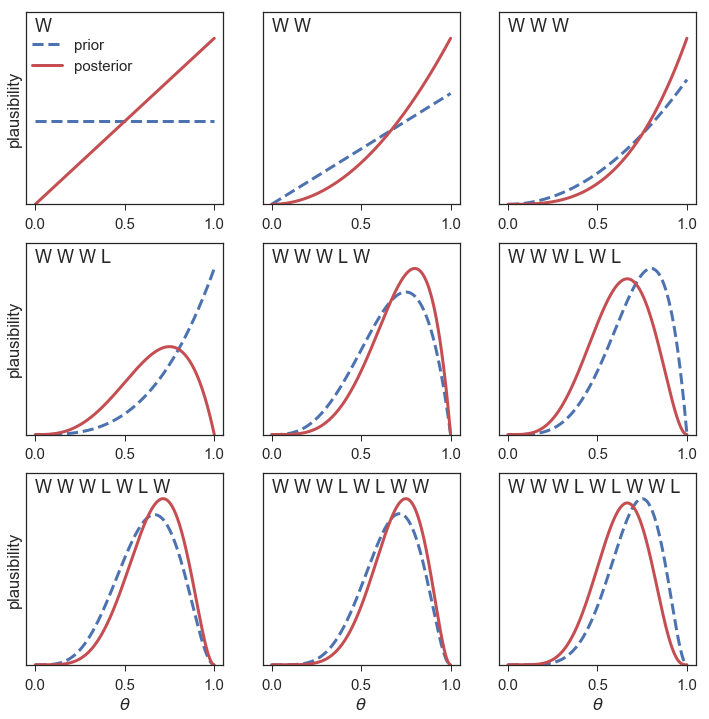

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(12,12))
axes = axes.ravel()
prob = np.ones(n_theta)
prob = prob/np.sum(prob)

d2 = np.concatenate((d[2:],d[:2])) # rearrange the data

title = []

for i,dv in enumerate(d2):
    title.append(wl[dv])
    l_prior, = axes[i].plot(theta,prob,'--',lw=3)
    like = bern(dv,theta)
    prob = prob * like
    prob = prob/np.sum(prob)
    l_post, = axes[i].plot(theta,prob,lw=3,color=red)
    y_up = axes[i].get_ylim()[1]
    axes[i].set(yticks=[], ylim=(0,1.1*y_up))
    if i in [0,3,6]:
        axes[i].set(ylabel='plausibility')
    if i > 5:
        axes[i].set(xlabel=r'$\theta$')
    axes[i].text(0,.9*axes[i].get_ylim()[1],' '.join(title))
    if i == 0:
        axes[i].legend([l_prior,l_post],['prior','posterior'],loc=(0,.65))

In this rearranged sequence, the first three observations are all W, so the posterior puts increasingly more emphasis on larger $\theta$ values, with the plausibility of one being increasingly emphasized. Then, the fourth observation is L, and suddenly one become an impossible value for $\theta$. After that, the changes are similar to the first illustration above

If we have prior knowledge about the parameters of a model (and we often do, even if it's only fairly vague), Bayesian statistical modeling allows us to incorporate prior knowledge into our model directly.

In this case, for example, we know ahead of time that values of $\theta$ near 0 or 1 are not plausible. We can use a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) to model our prior knowledge, indicating that we're pretty sure that $\theta$ is probably around 0.6 or so. A Beta random variable is parameterized by $\alpha$ and $\beta$:

\begin{equation}
\Pr(\theta | \alpha, \beta) \propto \theta^{\alpha-1}\left(1-\theta\right)^{\beta-1}
\end{equation}

Here, $\propto$ means "proportional to". The full equation has an additional constant term that ensures that the function integrates to one.

The mean of a Beta random variable is $\displaystyle{\frac{\alpha}{\alpha + \beta}}$ and the variance decreases as $\alpha$ and $\beta$ increase. So, in order to vaguely emphasize 0.6 in the prior, we will use a Beta(3,2) density:

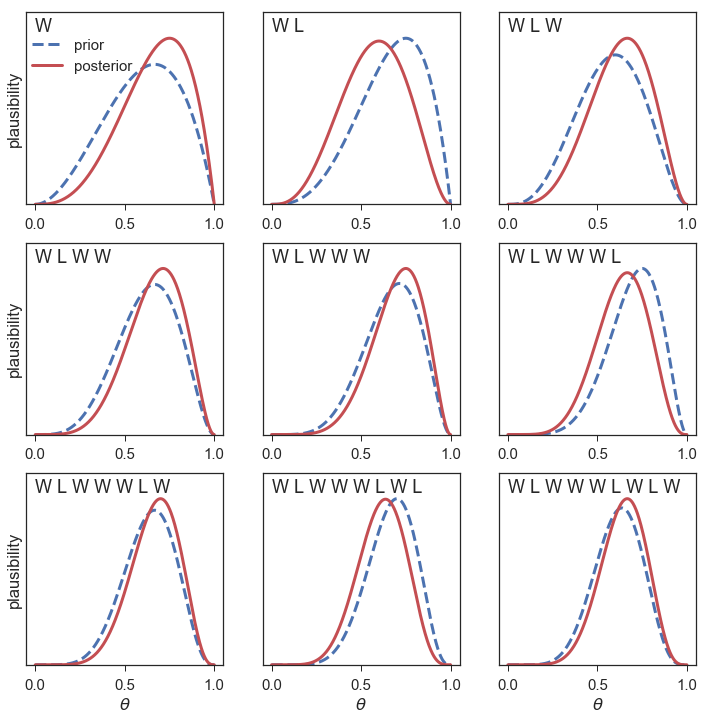

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(12,12))
axes = axes.ravel()
prob = beta.pdf(x=theta,a=3,b=2) # Beta(3,2) prior density
prob = prob/np.sum(prob)

title = []

for i,dv in enumerate(d):
    title.append(wl[dv])
    l_prior, = axes[i].plot(theta,prob,'--',lw=3)
    like = bern(dv,theta)
    prob = prob * like
    prob = prob/np.sum(prob)
    l_post, = axes[i].plot(theta,prob,lw=3,color=red)
    y_up = axes[i].get_ylim()[1]
    axes[i].set(yticks=[], ylim=(0,1.1*y_up))
    if i in [0,3,6]:
        axes[i].set(ylabel='plausibility')
    if i > 5:
        axes[i].set(xlabel=r'$\theta$')
    axes[i].text(0,.9*axes[i].get_ylim()[1],' '.join(title))
    if i == 0:
        axes[i].legend([l_prior,l_post],['prior','posterior'],loc=(0,.65))

Note that with this more informative prior, the changes from observation to observation are not as large, and the endpoint is different than it was in the previous two cases.

With this simple case, we can express the model mathematically and derive the formula for the posterior distribution for any particular sequence of observations.

Specifically, recall that we are using a Bernoulli likelihood:

\begin{equation}
\Pr(\mathbf{Y}=\mathbf{y}|\theta) = \prod_{i=1}^n\theta^{y_i} \left(1-\theta\right)^{1-y_i} = \theta^k \left(1-\theta \right)^{n-k}
\end{equation}

As shown above, the [Beta](https://en.wikipedia.org/wiki/Beta_distribution) prior looks very similar to the likelihood:

\begin{equation}
\Pr(\theta|\alpha,\beta) \propto \theta^{\alpha-1} \left(1-\theta \right)^{\beta-1}
\end{equation}

Given these two equations, we can easily write the equation for the posterior:

\begin{align}
\Pr(\theta|\mathbf{y},\alpha,\beta) &\propto \left(\theta^k \left(1-\theta \right)^{n-k}\right)\left(\theta^{\alpha-1} \left(1-\theta \right)^{\beta-1}\right)\\
&\propto \theta^{k+\alpha-1} \left(1-\theta\right)^{n-k+\beta-1}
\end{align}

Note that the uniform prior can be expressed as a Beta distribution with $\alpha = \beta = 1$. Hence, with the equation above, plugging in values for the uniform prior and the prior bunched around 0.6 ($\alpha=3, \beta=2$), we can get mathematical expressions for the posteriors illustrated in the last panels of the figures above (noting that $k=6$ and $n-k=3$):

\begin{align}
\Pr(\theta|k=6,\alpha=1,\beta=1) &\propto \theta^6\left(1-\theta\right)^3\\
\Pr(\theta|k=6,\alpha=3,\beta=2) &\propto \theta^8\left(1-\theta\right)^4
\end{align}


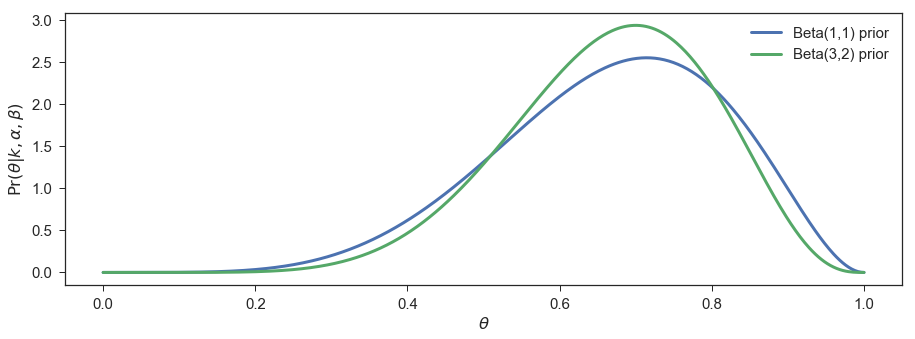

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
lu, = ax.plot(theta, beta.pdf(theta,6,3),lw=3)
ln, = ax.plot(theta, beta.pdf(theta,8,4),lw=3)
ax.set(xlabel=r'$\theta$', ylabel=r'$\Pr(\theta|k,\alpha,\beta)$')
ax.legend([lu,ln],['Beta(1,1) prior','Beta(3,2) prior']);

Thus far, we've been calculating the posterior distribution for $\theta$ using **grid approximation**. First, we created a vector of `n_theta` theta values, ranging from 0 to 1. Then we used this vector to calculate prior, likelihood, and posterior probability values for each value of $\theta$.

Grid approximation is fine for simple, unidimensional cases like this. We can also use it for slightly more complex analyses, where we have two parameters to estimate.

More specifically, we'll use grid approximation to estimate the mean and standard deviation for a Gaussian model of multiple measurements of the fundamental frequency from a single female talker from the McMurray & Jongman data set we used earlier in the semester.

We'll read in the whole data set and extract just the F0 data for talker F2, and visualize it:

(144, 33)


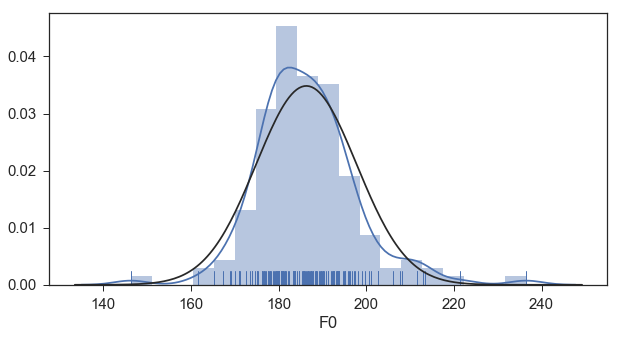

In [18]:
df = pd.read_csv('mnj_raw.csv')
dfs = df.loc[df['Talker']=='F2',:].copy()
print(dfs.shape)

fig, ax = plt.subplots(1,1,figsize=(10,5))
_ = sns.distplot(dfs['F0'], ax=ax, rug=True, fit=norm)

The Gaussian likelihood function for data $\mathbf{y}$ given $\mu$ and $\sigma$ is:

\begin{equation}
f\left(\mathbf{y}|\mu,\sigma^2\right) = \prod_{i=1}^N\frac{1}{\sqrt{2\pi \sigma^2}}\exp\left(-\frac{(y_i-\mu)^2}{2\sigma^2} \right)
\end{equation}

First, we'll do two dimensional grid approximation to estimate $\mu$ and $\sigma$ with flat priors across a wide range of values for both. Then we will estimate $\mu$ and $\sigma$ with more informative priors.

Without taking this specific data set into account, we know from many years of acoustic studies that women tend to have F0s around 200, but there is a lot of variation across speakers, so we will define a moderately informative prior for $\mu$ centered at 200 but with a fair amount of spread to allow for variation. A moderately informative prior for sigma is more difficult to establish based on *a priori* reasoning. We will model $\sigma$ as a [gamma random variable](https://en.wikipedia.org/wiki/Gamma_distribution), which is defined for positive real numbers. We will center it at 15, and, as with the model for $\mu$, we will allow for a fair amount of spread to encode our relatively uncertain state of knowledge about the range of reasonable values for $\sigma$.

We'll do each of these for a randomly selected subset of 5 values of the F0 data, then we'll do it again for the full set of 144 values. Note that we are assuming (with good reason, as it happens) that $\mu$ and $\sigma$ are independent, which allows us to define the priors for these parameters in unidimensional vectors, multiplying probabilities/likelihoods for specific combinations to get the joint probabilities/likelihoods.

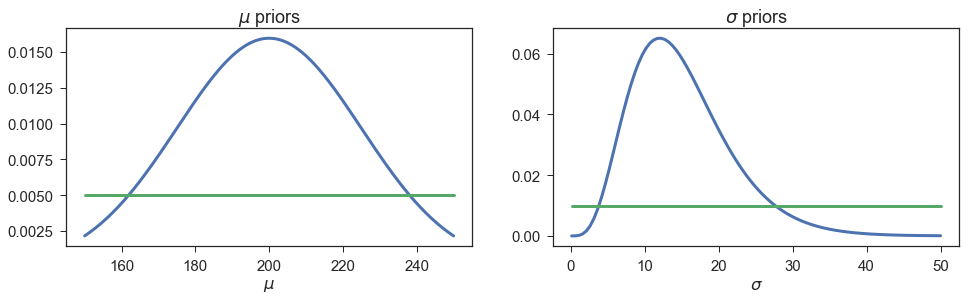

In [19]:
n_mu = 200 # number of mu values to consider
mu = np.linspace(150,250,n_mu) # mu values
p_mu = norm.pdf(mu, loc=200, scale=25) # normal mu prior
u_mu = np.ones(n_mu); u_mu = u_mu/u_mu.sum() # uniform mu prior

n_sigma = 100 # number of sigma values to consider
sigma = np.linspace(0.1,50,n_sigma) # sigma values
p_sigma = gamma.pdf(sigma, a=5, scale=3) # mean = 5*3 = 15, SD = sqrt(5)*3
u_sigma = np.ones(n_sigma); u_sigma = u_sigma/u_sigma.sum() # uniform sigma prior

fig, axes = plt.subplots(1, 2, figsize=(16,4))
ax_mu, ax_sigma = axes
ax_mu.plot(mu,p_mu,lw=3)
ax_mu.plot(mu,u_mu,lw=3)
ax_mu.set(xlabel=r'$\mu$')
ax_mu.set_title(r'$\mu$ priors')
ax_sigma.plot(sigma, p_sigma,lw=3)
ax_sigma.plot(sigma, u_sigma,lw=3)
ax_sigma.set(xlabel=r'$\sigma$')
ax_sigma.set_title(r'$\sigma$ priors');

In [31]:
##### F0 = dfs['F0'].as_matrix() # extract just the F0 data
np.random.seed(seed=95238) # set the RNG seed
indices = np.random.permutation(len(F0)) # for shuffling F0 values
F0s = F0[indices[:5]] # pick out the first five
F0s # look at them

array([ 187.4163566,  195.2217758,  236.4883716,  185.4390527,  196.6754329])

In [32]:
post_ms = np.zeros((2,n_mu,n_sigma)) # 0 = uniform prior, 1 = non-uniform prior

for mu_i, mu_v in enumerate(mu):
    for sg_i, sg_v in enumerate(sigma):
        like = np.prod(norm.pdf(F0s, loc=mu_v, scale=sg_v)) # likelihood function for mu_v, sg_v
        post_ms[0,mu_i,sg_i] = like*u_mu[mu_i]*u_sigma[sg_i] # posterior w/ uniform prior
        post_ms[1,mu_i,sg_i] = like*p_mu[mu_i]*p_sigma[sg_i] # posterior w/ non-uniform prior

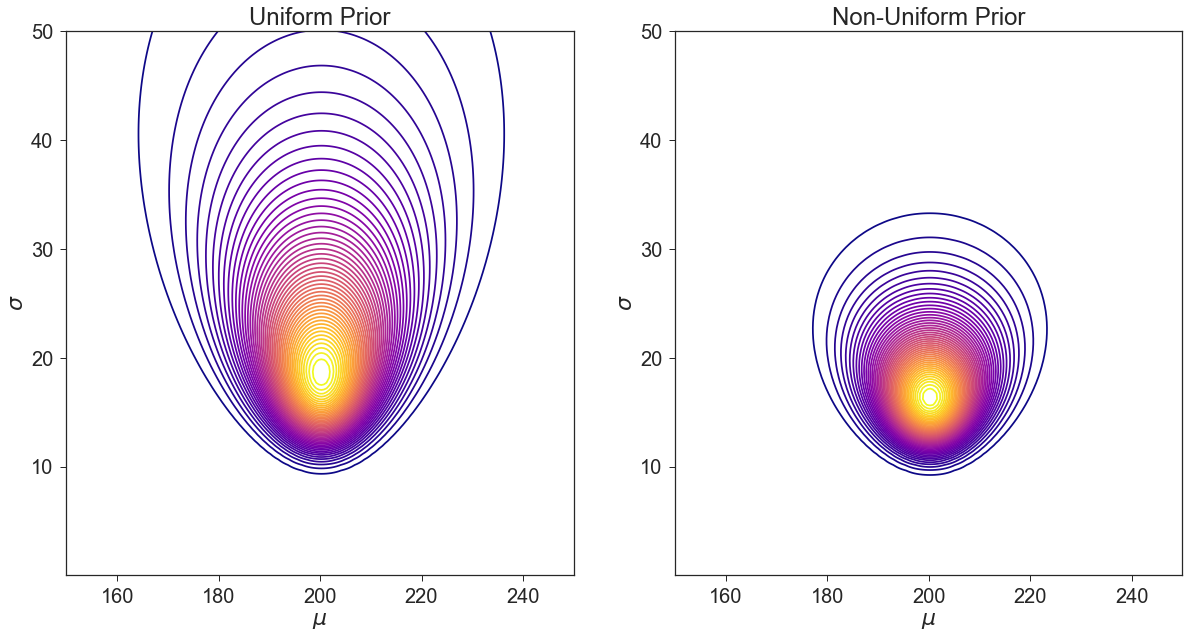

In [33]:
sns.set(style='ticks', font_scale=2)
MU, SIGMA = np.meshgrid(mu, sigma) # 2D arrays of mu and sigma values
n_levels = 50 # number of contour levels
lev_u = np.linspace(0,post_ms[0,:,:].max(),n_levels) # for uniform prior
lev_p = np.linspace(0,post_ms[1,:,:].max(),n_levels) # for non-uniform prior
fig, axes = plt.subplots(1, 2, figsize=(20,10))
ax_u, ax_p = axes
ax_u.contour(MU, SIGMA, post_ms[0,:,:].T, levels=lev_u, cmap='plasma')
ax_u.set_title('Uniform Prior'); ax_u.set(xlabel=r'$\mu$', ylabel=r'$\sigma$')
ax_p.contour(MU, SIGMA, post_ms[1,:,:].T, levels=lev_p, cmap='plasma')
ax_p.set_title('Non-Uniform Prior'); ax_p.set(xlabel=r'$\mu$', ylabel=r'$\sigma$');

With just five data points (and with these five in particular), the priors end up influencing the posterior quite a bit. The uniform prior produces a much broader posterior for both $\mu$ and $\sigma$, whereas the additional information encoded in the non-uniform prior constrains both parameters substantially.

We can estimate the marginal distributions for $\mu$ and $\sigma$ using the 2D arrays containing our grid approximations for the joint posterior for both parameters.

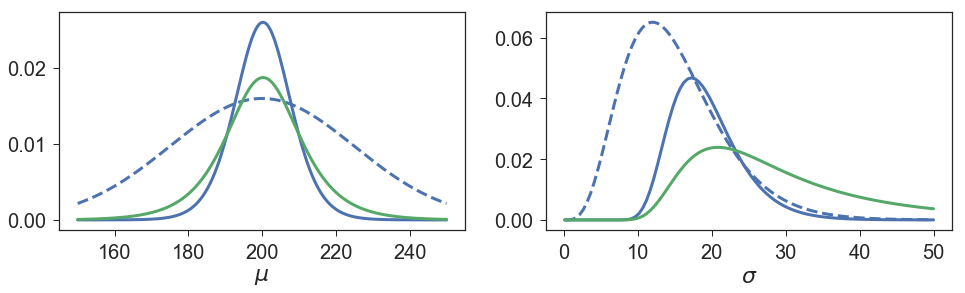

In [34]:
post_mu_u = post_ms[0,:,:].sum(axis=1); post_mu_u = post_mu_u/post_mu_u.sum() # marginalize mu, uniform prior
post_mu_p = post_ms[1,:,:].sum(axis=1); post_mu_p = post_mu_p/post_mu_p.sum() # marginalize mu, non-uniform prior

post_sg_u = post_ms[0,:,:].sum(axis=0); post_sg_u = post_sg_u/post_sg_u.sum() # marginalize sigma, uniform
post_sg_p = post_ms[1,:,:].sum(axis=0); post_sg_p = post_sg_p/post_sg_p.sum() # marginalize sigma, non-uniform

fig, axes = plt.subplots(1, 2, figsize=(16,4))
ax_mu, ax_sigma = axes.ravel()
ax_mu.plot(mu,p_mu,'--',color=blue, lw=3)
ax_mu.plot(mu,post_mu_p,color=blue, lw=3)
ax_mu.plot(mu,post_mu_u,color=green, lw=3)
ax_mu.set(xlabel=r'$\mu$')
ax_sigma.plot(sigma, p_sigma,'--',color=blue, lw=3)
ax_sigma.plot(sigma, post_sg_p, color=blue, lw=3)
ax_sigma.plot(sigma, post_sg_u,color=green, lw=3)
ax_sigma.set(xlabel=r'$\sigma$');

If we use the full data set (all 144 values of F0), the data overwhelms even the non-uniform prior used above. We will constrain the range of $\mu$ and $\sigma$ values under consideration in order to more clearly illustrate this, since the narrowness of the likelihood function with the full data set makes many of the values of $\mu$ and $\sigma$ considered above irrelevant.

In [35]:
n_mu = 200
mu = np.linspace(180,192,n_mu)
p_mu = norm.pdf(mu, loc=200, scale=25)
u_mu = np.ones(n_mu); u_mu = u_mu/u_mu.sum()

n_sigma = 100
sigma = np.linspace(8,16,n_sigma)
p_sigma = gamma.pdf(sigma, a=5, scale=3) # mean = 5*3 = 15, SD = sqrt(5)*3
u_sigma = np.ones(n_sigma); u_sigma = u_sigma/u_sigma.sum()

post_ms = np.zeros((2,n_mu,n_sigma)) # 0 = uniform prior, 1 = non-uniform prior

for mu_i, mu_v in enumerate(mu):
    for sg_i, sg_v in enumerate(sigma):
        like = np.prod(norm.pdf(F0, loc=mu_v, scale=sg_v))
        post_ms[0,mu_i,sg_i] = like*u_mu[mu_i]*u_sigma[sg_i]
        post_ms[1,mu_i,sg_i] = like*p_mu[mu_i]*p_sigma[sg_i]

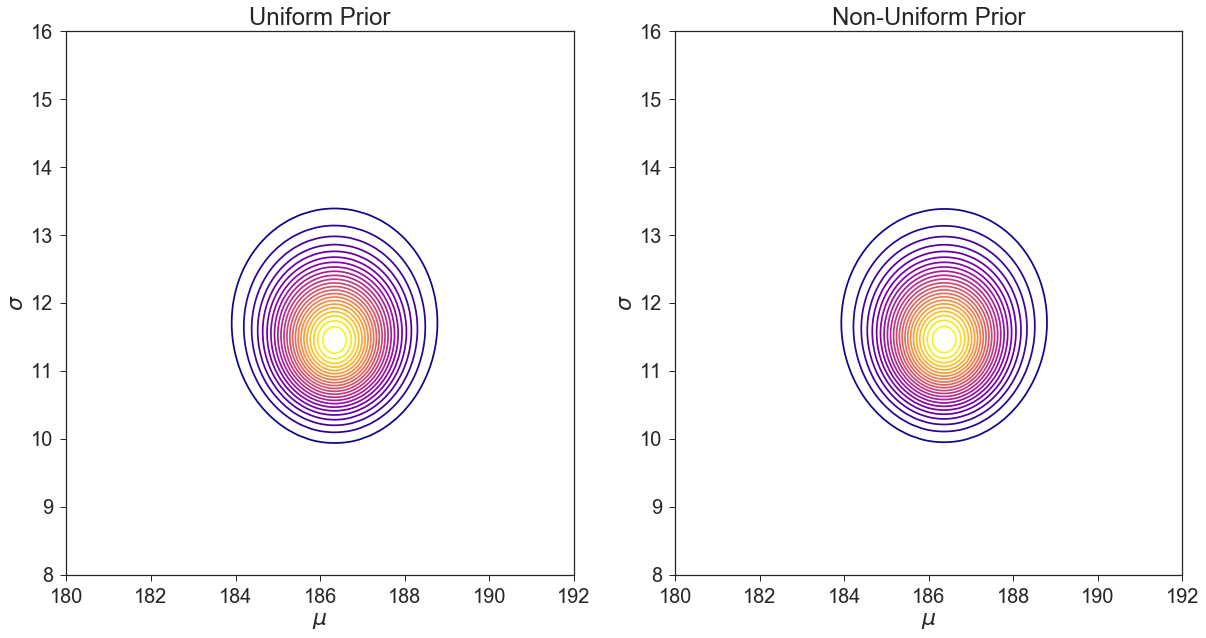

In [36]:
MU, SIGMA = np.meshgrid(mu, sigma)
n_levels = 25
lev_u = np.linspace(0,post_ms[0,:,:].max(),n_levels)
lev_p = np.linspace(0,post_ms[1,:,:].max(),n_levels)
fig, axes = plt.subplots(1, 2, figsize=(20,10))
ax_u, ax_p = axes
ax_u.contour(MU, SIGMA, post_ms[0,:,:].T, levels=lev_u, cmap='plasma')
ax_u.set_title('Uniform Prior'); ax_u.set(xlabel=r'$\mu$', ylabel=r'$\sigma$')
ax_p.contour(MU, SIGMA, post_ms[1,:,:].T, levels=lev_p, cmap='plasma');
ax_p.set_title('Non-Uniform Prior'); ax_p.set(xlabel=r'$\mu$', ylabel=r'$\sigma$');

Both of these posteriors look (very close to) identical. In both of these cases, the likelihood more or less completely determines the properties of the posterior.

Again, we can calculate the marginal density (estimates) for $\mu$ and $\sigma$ to illustrate this for each parameter on its own. The restricted range of values we are considering emphasize how unimportant the priors are in this case.

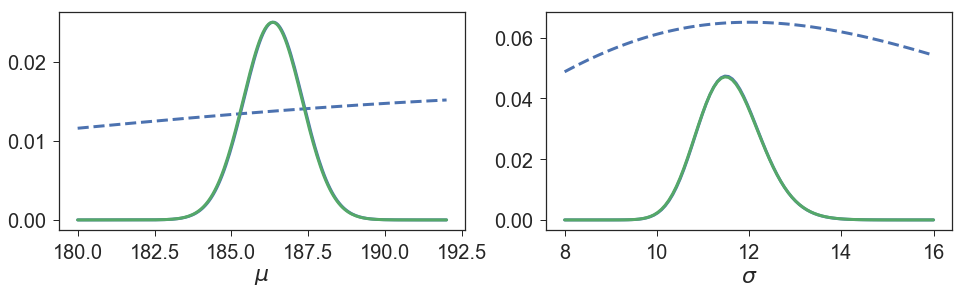

In [37]:
post_mu_u = post_ms[0,:,:].sum(axis=1); post_mu_u = post_mu_u/post_mu_u.sum()
post_mu_p = post_ms[1,:,:].sum(axis=1); post_mu_p = post_mu_p/post_mu_p.sum()

post_sg_u = post_ms[0,:,:].sum(axis=0); post_sg_u = post_sg_u/post_sg_u.sum()
post_sg_p = post_ms[1,:,:].sum(axis=0); post_sg_p = post_sg_p/post_sg_p.sum()

fig, axes = plt.subplots(1, 2, figsize=(16,4))
ax_mu, ax_sigma = axes.ravel()
ax_mu.plot(mu,p_mu,'--',color=blue, lw=3)
ax_mu.plot(mu,post_mu_p,color=blue, lw=3)
ax_mu.plot(mu,post_mu_u,color=green, lw=3)
ax_mu.set(xlabel=r'$\mu$')
ax_sigma.plot(sigma, p_sigma,'--',color=blue, lw=3)
ax_sigma.plot(sigma, post_sg_p, color=blue, lw=3)
ax_sigma.plot(sigma, post_sg_u,color=green, lw=3)
ax_sigma.set(xlabel=r'$\sigma$');

## Summary

As noted above, with more than one dimension (and even sometimes with just one dimension), grid approximation can be extremely computationally expensive. It is not, in general, a useful method for estimating the posterior probability distribution in realistic research settings.

In addition, the posterior distributions for the parameters of most models that you would actually use in research (e.g., Bayesian versions of the regression and logistic regression models we've discussed in previous weeks) do not have readily available mathematical formulas.

Thankfully, Bayesian data analysis with useful, often complex models, is possible due to the development of a number of powerful software packages. Generally speaking, these packages are designed to take a high-level model specification and data as input and return samples from the posterior distribution. These samples can then be used to describe and draw inferences about the posterior distribution of parameters of interest and generate predictions of future data.

[JAGS](http://mcmc-jags.sourceforge.net/) is one such package, though it does not have a well-developed Python interface. [PyMC](https://pymc-devs.github.io/pymc/) is a native Python library, and [PyStan](https://pystan.readthedocs.io/en/latest/) is a Python interface for the Stan probabilistic programming language (i.e., Bayesian modeling software). Note that PyMC 3 is similar to Stan (though less well-developed), and very different from PyMC 2, which is, in turn, reasonably similar to JAGS. We'll talk about all this next time.